In [10]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")) + '/lib/')
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lib.blob_extraction import img_preprocess_mask, img_preprocess, blob_detect, get_nodes_pos
from lib.graph_generate import Plot_Voronoi_Graph, hexagon_voronoi_graph_built
from lib.voronoi_generate import TransformVoronoi_127, cal_3d_Voronoi, plot_3d_Voronoi

## 1. Blob Extraction

Raw image size:  (256, 256, 3)


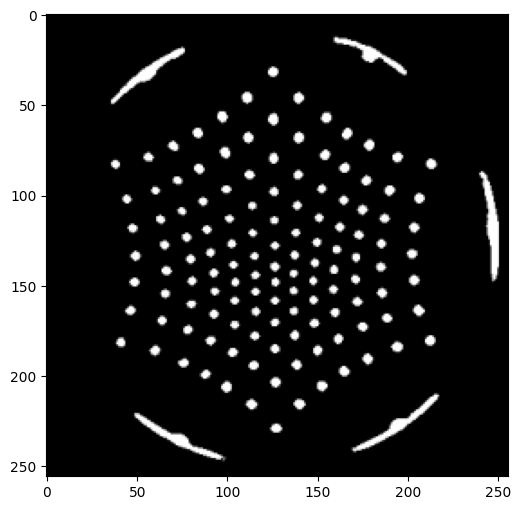

In [11]:
## (1) Read Image

# test_data_path = r"/home/dd/4-Wen-Codes/Tactile_servoing/collect_data/new_dataset/tactip-127/model_surface2d/train/frames_bw/frame_50_0.png" ## hexgon data
test_data_path = os.path.abspath(os.path.join(os.getcwd(), "..")) + r"\data\127\model_surface2d\frames_bw\frame_0_0.png" ## hexgon example

frame= cv2.imread(test_data_path)
print("Raw image size: ", frame.shape)

plt.figure(figsize=(6, 6))
plt.imshow(frame)
plt.show()

Processed image size:  (256, 256)


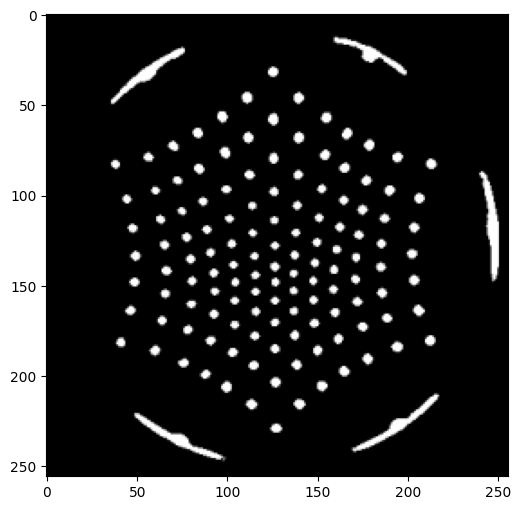

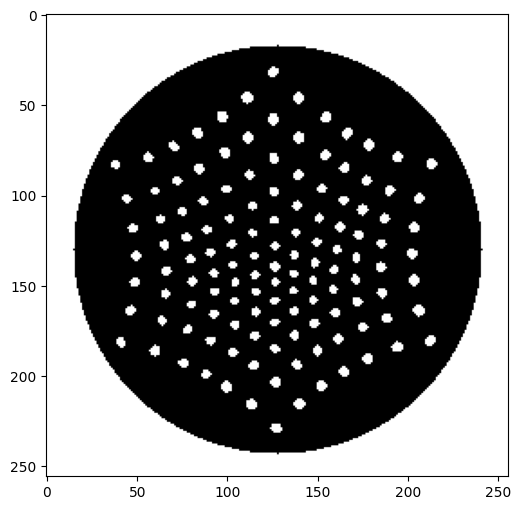

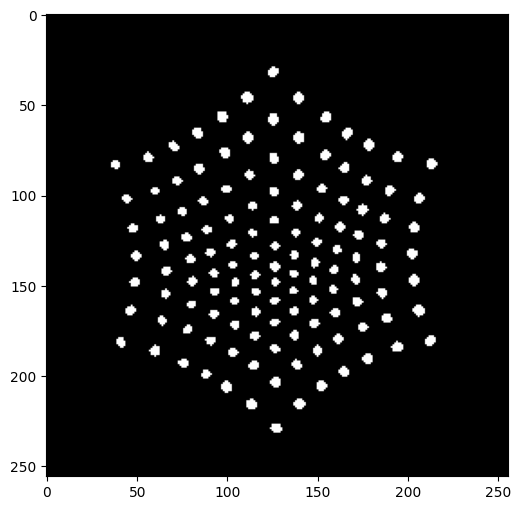

In [12]:
## (2) Image Preprocess

processed, white_mask, erosion = img_preprocess_mask(frame, 
                                                     erosion = True,
                                                     resize_x = 256, 
                                                     resize_y = 256, 
                                                     kernel_size = 1, 
                                                     binary_threshold = 80, 
                                                     circle_x_bias=0, 
                                                     circle_y_bias=2,
                                                     circle_radius_bias=-15)  ## setup the mask parameter

print("Processed image size: ", processed.shape)

plt.figure(figsize=(6, 6))
plt.imshow(erosion, cmap = 'gray')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(white_mask, cmap = 'gray')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(processed, cmap = 'gray')
plt.show()

Detected blob number:  127


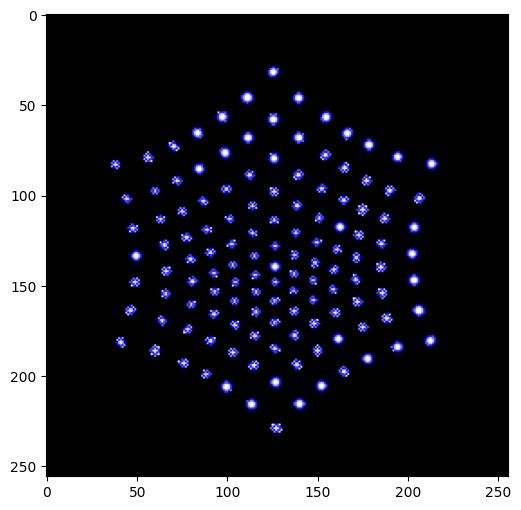

In [13]:
## (3) Blob Detection

keypoints = blob_detect(processed, minArea = 1, blobColor = 255, 
                        minCircularity = 0.01, minConvexity = 0.01, 
                        minInertiaRatio = 0.01, thresholdStep = 5,
                        minDistBetweenBlobs = 3.0, minRepeatability = 3)

print("Detected blob number: ", len(keypoints))

im_with_keypoints = cv2.drawKeypoints(processed, keypoints, np.array([]), (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(6, 6))
plt.imshow(im_with_keypoints, cmap = 'gray')
plt.show()

In [14]:
## (4) Node Position

nodes_pos = get_nodes_pos(keypoints)  ##catch nodes'position

nodes_pos_norm = np.squeeze(nodes_pos)
_, unindx = np.unique(nodes_pos_norm, return_index=True, axis=0)
unindx = np.sort(unindx)
nodes_pos_norm = nodes_pos_norm[unindx]
nodes_pos_norm = (nodes_pos_norm - np.median(nodes_pos_norm))
print("Node position size: ", nodes_pos_norm.shape)

Node position size:  (127, 2)


## 2. Voronoi Graph Generation

Voronoi region area number:  127
Voronoi region center number:  127


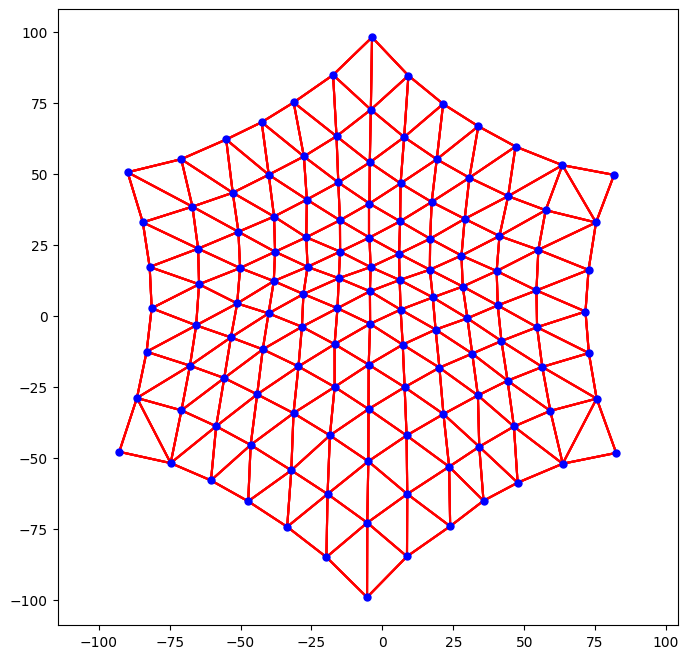

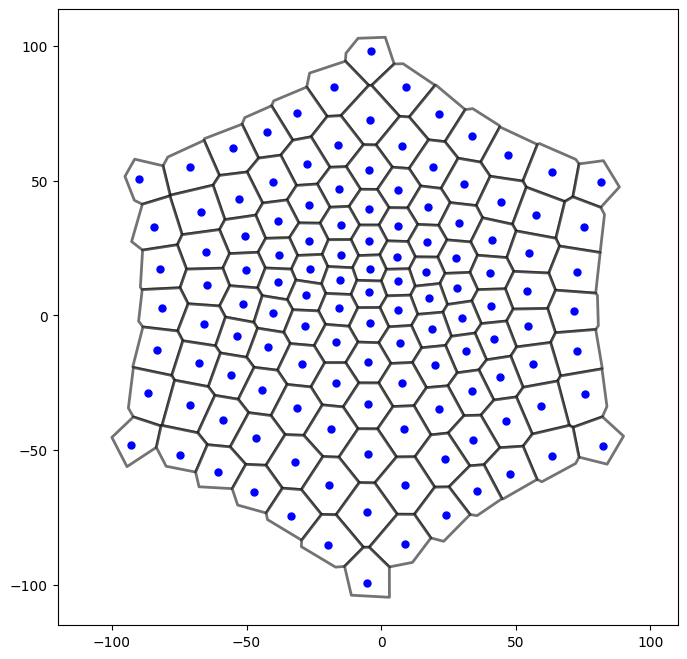

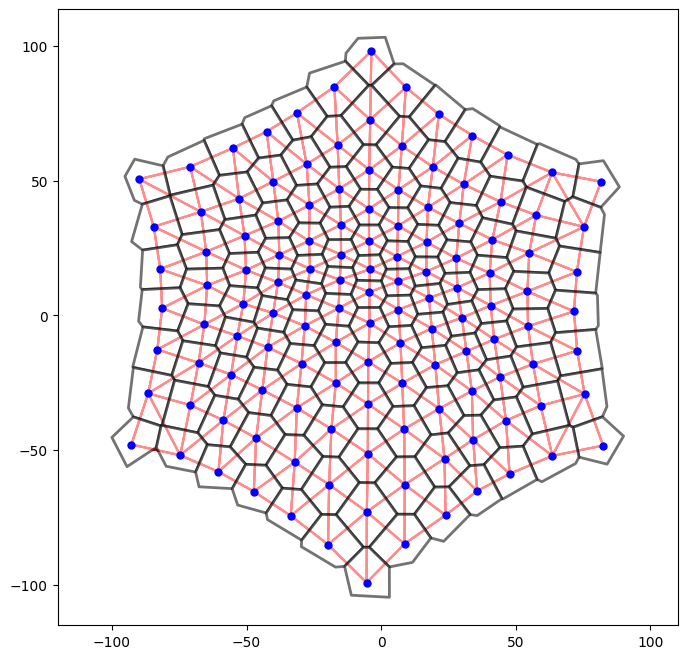

In [15]:
## (1) Voronoi Graph Build

## Calculate voronoi tesseleation
Axx_canon, Cxx_canon, Cyy_canon, XY_canon = TransformVoronoi_127(borderScale=1.1).transform(nodes_pos)
print('Voronoi region area number: ', len(Axx_canon))
print('Voronoi region center number: ', len(XY_canon))

clean_nodes_edges, nodes_pos_norm = hexagon_voronoi_graph_built(nodes_pos)

p1 = Plot_Voronoi_Graph(cell_areas = Axx_canon, cellvert_xcoord = Cxx_canon, cellvert_ycoord = Cyy_canon, cell_center = XY_canon, nodes_edges=clean_nodes_edges).plotGraph(cell_scale_fact=1)
p2 = Plot_Voronoi_Graph(cell_areas = Axx_canon, cellvert_xcoord = Cxx_canon, cellvert_ycoord = Cyy_canon, cell_center = XY_canon, nodes_edges=clean_nodes_edges).plotVoronoi(cell_scale_fact=1)
p3 = Plot_Voronoi_Graph(cell_areas = Axx_canon, cellvert_xcoord = Cxx_canon, cellvert_ycoord = Cyy_canon, cell_center = XY_canon, nodes_edges=clean_nodes_edges).plotVoronoiGraph(cell_scale_fact=1)


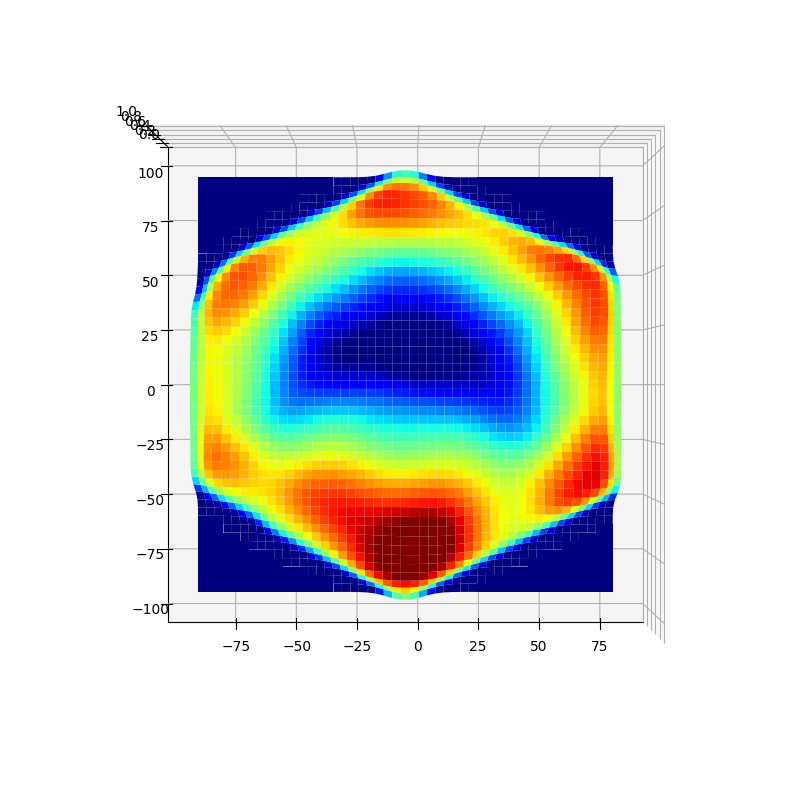

In [16]:
## (2) Plot Voronoi Graph

Xgrid, Ygrid, Z_canon = cal_3d_Voronoi(Axx_canon, Cxx_canon, Cyy_canon, pool_neighbours = 3, num_interp_points = 50)

plot_3d_Voronoi(Xgrid, Ygrid, Z_canon, vmin=0.1, vmax=0.9)

## 3. Voronoi Graph Change

In [17]:
def construct_voronoi_graph(path):
    
    frame= cv2.imread(path)

    processed = img_preprocess(frame, 
                               erosion = True,
                                resize_x = 256, 
                                resize_y = 256, 
                                kernel_size = 1, 
                                binary_threshold = 80, 
                                circle_x_bias=0, 
                                circle_y_bias=2,
                                circle_radius_bias=-15) 
    
    keypoints = blob_detect(processed, minArea = 1, blobColor = 255, 
                        minCircularity = 0.01, minConvexity = 0.01, 
                        minInertiaRatio = 0.01, thresholdStep = 5,
                        minDistBetweenBlobs = 3.0, minRepeatability = 3)
    
    nodes_pos = get_nodes_pos(keypoints)  
    
    Axx_canon, Cxx_canon, Cyy_canon, XY_canon = TransformVoronoi_127(borderScale=1.1).transform(nodes_pos)

    clean_nodes_edges, nodes_pos_norm = hexagon_voronoi_graph_built(nodes_pos)

    return Axx_canon, Cxx_canon, Cyy_canon, XY_canon, clean_nodes_edges

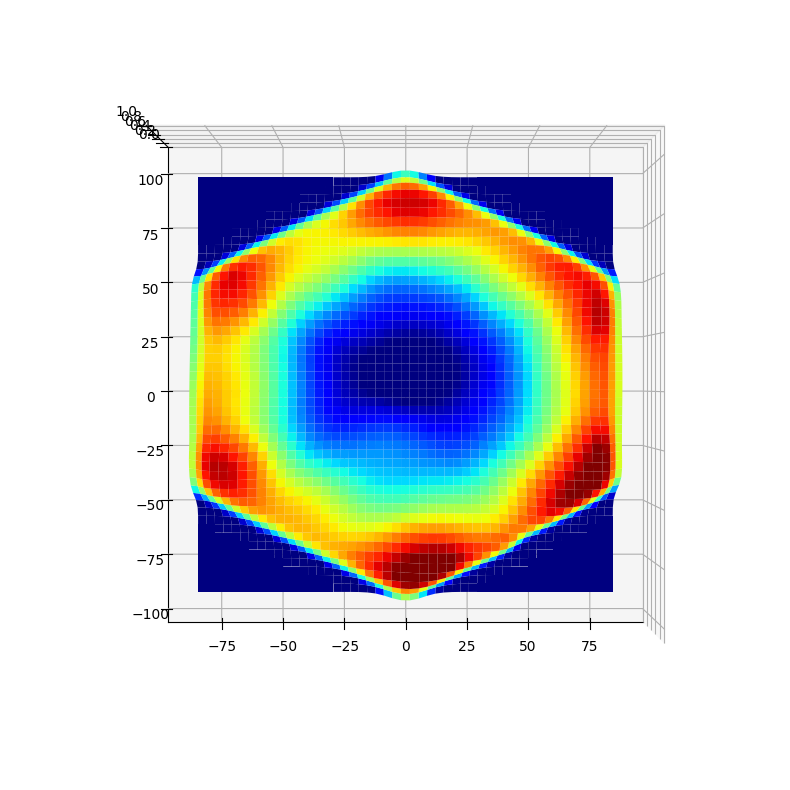

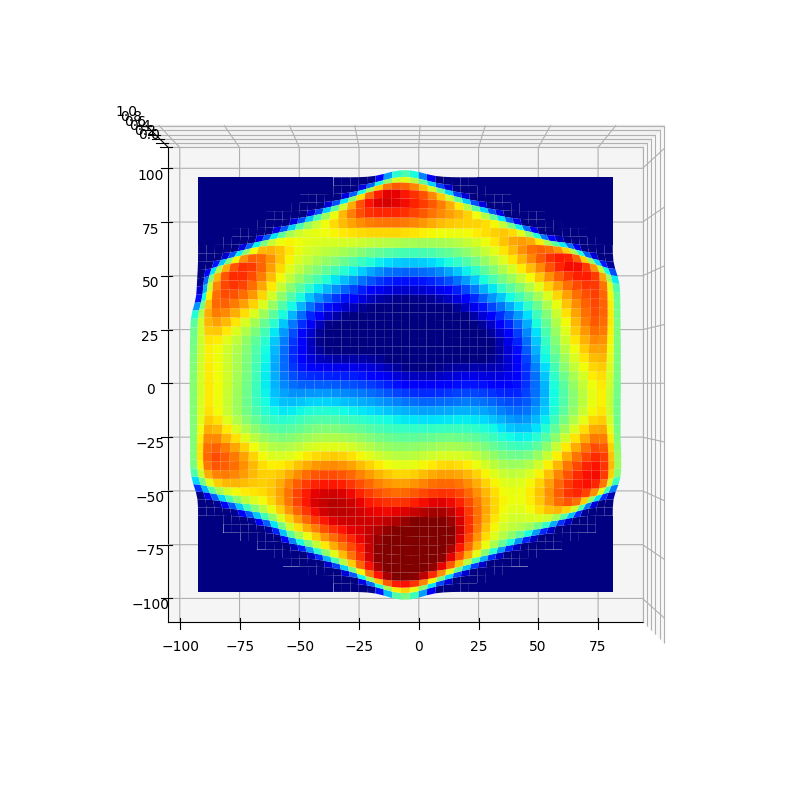

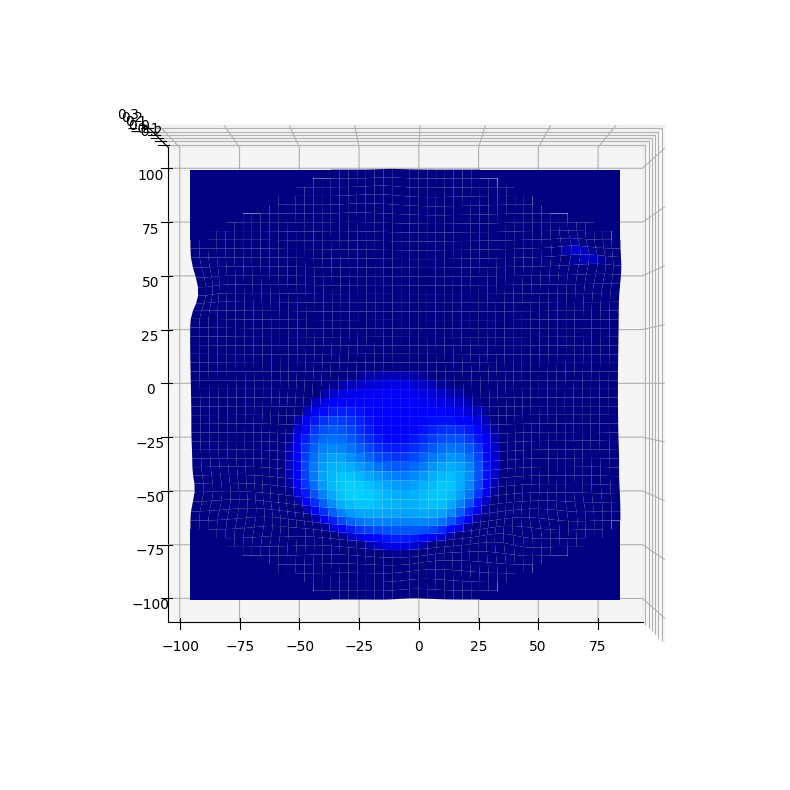

In [18]:
ref_data_path = os.path.abspath(os.path.join(os.getcwd(), "..")) + r"\data\127\model_surface2d\frames_bw\frame_608_0.png" ## ref hexgon example
test_data_path = os.path.abspath(os.path.join(os.getcwd(), "..")) + r"\data\127\model_surface2d\frames_bw\frame_599_0.png" ## test hexgon example

Axx_canon_r, Cxx_canon_r, Cyy_canon_r, XY_canon_r, XY_edges_r = construct_voronoi_graph(ref_data_path)

Axx_canon_t, Cxx_canon_t, Cyy_canon_t, XY_canon_t, XY_edges_t = construct_voronoi_graph(test_data_path)

Xgrid_r, Ygrid_r, Z_canon_r = cal_3d_Voronoi(Axx_canon_r, Cxx_canon_r, Cyy_canon_r, pool_neighbours = 3, num_interp_points = 50)

Xgrid_t, Ygrid_t, Z_canon_t = cal_3d_Voronoi(Axx_canon_t, Cxx_canon_t, Cyy_canon_t, pool_neighbours = 3, num_interp_points = 50)

Z_canon_diff = Z_canon_t - Z_canon_r  ## calculate the difference between ref voronoi graph and test voronoi graph

plot_3d_Voronoi(Xgrid_r, Ygrid_r, Z_canon_r, vmin=0.1, vmax=0.9)
plot_3d_Voronoi(Xgrid_t, Ygrid_t, Z_canon_t, vmin=0.1, vmax=0.9)
plot_3d_Voronoi(Xgrid_t, Ygrid_t, Z_canon_diff, vmin=0.1, vmax=0.9)
